In [3]:
%pip install --quiet --upgrade pip jupysql ipywidgets ipympl pandas matplotlib jupyterlab pyarrow numpy scipy statsmodels tabulate

Note: you may need to restart the kernel to use updated packages.


In [4]:
## getting the imports out of the way
import pandas as pd
idx = pd.IndexSlice
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib widget

#activity colour map
colours = {
    'uncategorised': plt.cm.tab20(0),
    'sync': plt.cm.tab20(1),
    'load': plt.cm.tab20(2),
    'deserialize': plt.cm.tab20(3),
    'sensor_init': plt.cm.tab20(4),
    'net_init': plt.cm.tab20(5),
    'collect': plt.cm.tab20(6),
    'exec_tflite': plt.cm.tab20(7),
    'exec_query': plt.cm.tab20(8),
    'send': plt.cm.tab20(9),
    'save_config': plt.cm.tab20(10),
    'sleep': plt.cm.tab20(11),
    'riot_os_init': plt.cm.tab20(12),
}

In [5]:
experiments_and_query_lengths = {
    "404571": 16,
    "404572": 32,
    "404573": 64,
    "404627": 114,
}

In [6]:
# load all the parquet files
experiment_dfs = {}
for k,v in experiments_and_query_lengths.items():
    experiment_dfs[v] = pd.read_parquet(f"./parquets/{k}.parquet")
    print(f"loaded {k} with columns {list(experiment_dfs[v].columns)}")

loaded 404571 with columns ['node_id', 'timestamp', 'power', 'current', 'voltage', 'activity', 'loop_num']
loaded 404572 with columns ['node_id', 'timestamp', 'power', 'current', 'voltage', 'activity', 'loop_num']
loaded 404573 with columns ['node_id', 'timestamp', 'power', 'current', 'voltage', 'activity', 'loop_num']
loaded 404627 with columns ['node_id', 'timestamp', 'power', 'current', 'voltage', 'activity', 'loop_num']


We need to calculate joule for each device. We do by finding the change in time in seconds multiplied by the watt measurement for that period. That gives us joules consumed for that period

In [7]:
# now figure out the power consumed per activity
# we do this by figuring out what the total power consumed is per node_id.
# to find that we need the time difference between each timestamp and the previous one in seconds and then multiply that with the wattage to get power consumed in WattSeconds or joule for that time slice.
# we then sum over the whole activity to get the total count of joules
joule_per_activity_node_per_query = {}
for k,v in experiment_dfs.items():
    v["timestamp_diff"]  = v.groupby(["node_id"], observed=True)["timestamp"].diff()
    v["joule"] = v["timestamp_diff"].dt.total_seconds() * v["power"]
    joule_per_activity_node_per_query[k] = v.groupby(["node_id", "loop_num", "activity"], observed=True)["joule"].sum().reset_index()

In [8]:
experiment_dfs[16]

,node_id,timestamp,power,current,voltage,activity,loop_num,timestamp_diff,joule
0,70B3D57ED005EA59,2024-08-30 14:54:52.748617,0.288753,0.058239,4.95750,uncategorised,NaN,NaT,NaN
1,70B3D57ED005EA59,2024-08-30 14:54:52.749746,0.288143,0.058141,4.95625,uncategorised,NaN,0 days 00:00:00.001129,0.000325
2,70B3D57ED005EA59,2024-08-30 14:54:52.750875,0.286922,0.057751,4.96000,uncategorised,NaN,0 days 00:00:00.001129,0.000324
3,70B3D57ED005EA59,2024-08-30 14:54:52.751973,0.288753,0.058141,4.95750,uncategorised,NaN,0 days 00:00:00.001098,0.000317
4,70B3D57ED005EA59,2024-08-30 14:54:52.753102,0.286922,0.057824,4.95125,uncategorised,NaN,0 days 00:00:00.001129,0.000324
...,...,...,...,...,...,...,...,...,...
28961433,70B3D57ED005EA68,2024-08-30 15:54:58.456589,0.253956,0.052159,4.86250,sleep,25.0,0 days 00:00:00.001068,0.000271
28961434,70B3D57ED005EA68,2024-08-30 15:54:58.457687,0.255177,0.052403,4.86125,sleep,25.0,0 days 00:00:00.001098,0.000280
28961435,70B3D57ED005EA68,2024-08-30 15:54:58.458755,0.253956,0.052232,4.86000,sleep,25.0,0 days 00:00:00.001068,0.000271
28961436,70B3D57ED005EA68,2024-08-30 15:54:58.459854,0.253346,0.052061,4.86125,sleep,25.0,0 days 00:00:00.001099,0.000278


In [9]:
# now we need to split this into two datasets, one for first loop, and one for the rest
first_loop_joules = {
    k: v[v["loop_num"] < 1.0] for k,v in joule_per_activity_node_per_query.items()
}

rest_joules = {
    k: v[v["loop_num"] >= 1.0] for k,v in joule_per_activity_node_per_query.items()
}

# STARTUP ANALYSIS
We cant do startup analysis on prebaked queries since there is no network transfer.

<!-- $QL$ affects several parameters in the first loop:

| **Model Equation**                                           | **Description**                               |
| ------------------------------------------------------------ | --------------------------------------------- |
| $StartupEnergy_{SendReceive} = \alpha + \beta QL + \epsilon$ | Send/receive energy (linear, single variable) |
| $StartupEnergy_{SaveConfig} = \alpha + \beta QL + \epsilon$  | Save configuration energy                     |

To get an overview of the data we first plot the first two loop of every device in the $QL = 16$ dataset -->

| **Model Equation**                                | **Description**                               |
| ------------------------------------------------- | --------------------------------------------- |
| $StartupEnergy_{SendReceive} = \alpha + \beta QL$ | Send/receive energy (linear, single variable) |
| $StartupEnergy_{SaveConfig} = \alpha + \beta QL$  | Save configuration energy                     |



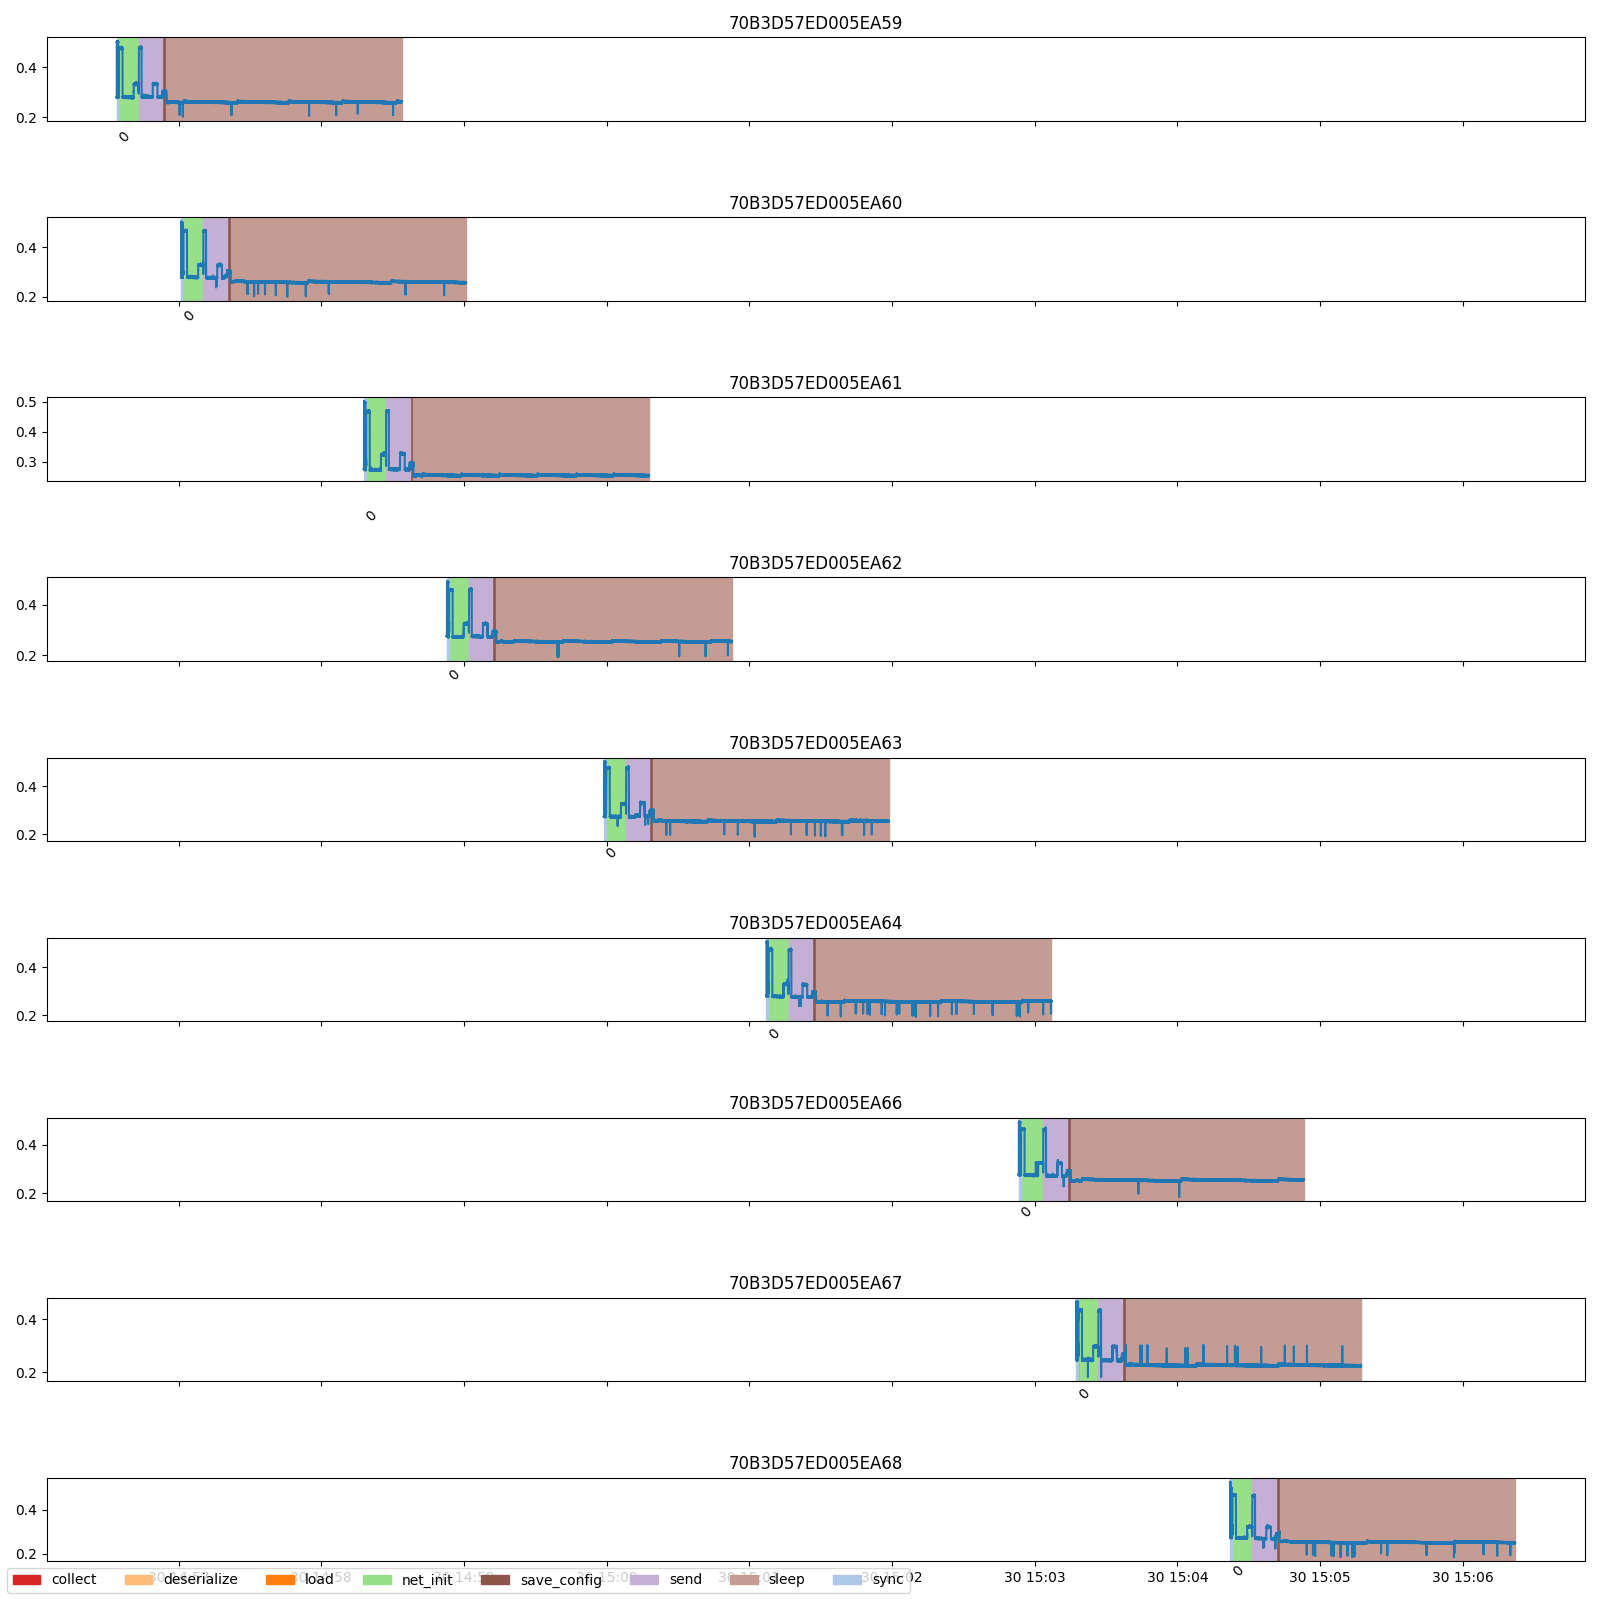

In [10]:
#for fun lets plot the loops we are gonna analyse on

df =list(experiment_dfs.values())[0]
node_ids = df["node_id"].unique()

fig, axs = plt.subplots(len(node_ids), 1, figsize=(16,16), sharex=True)

for i, node_id in enumerate(node_ids):
    # select only current node_id and loop 1+
    data = df[(df["node_id"] == node_id) & (df["loop_num"] < 1.0) & (df["activity"] != "uncategorised")]
    timings = data.groupby(["loop_num", "activity"], observed=True)["timestamp"].agg(["first", "last"])
    for (loop, activity),v in timings.iterrows():
        axs[i].axvspan(v["first"], v["last"], alpha=1, color=colours[activity], label=activity)
    # write loop numbers on the plot
    for name, group in data.groupby(["loop_num"], observed=True)["timestamp"]:
        axs[i].text(group.iloc[0], 0.1, f"{int(name[0])}" , fontsize=10, rotation=45)

    axs[i].plot(data["timestamp"], data["power"])
    axs[i].set_title(node_id)


# avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc="lower left", ncol=len(by_label))
fig.tight_layout()
plt.show()

In [34]:
def plot_joules(data, activity):
    x = []
    y = []
    
    for k,v in data.items():
        d = v[v["activity"] == activity]
        x.extend([k for _ in range(len(d))])
        y.extend(d["joule"])
        is_startup = len(v[v["loop_num"] < 1.0]) > 0
            

    res = stats.linregress(x,y)

    plt.figure(figsize=(11,6))
    for k,v in data.items():
        d = v[v["activity"] == activity]
        plt.scatter([k for _ in range(len(d))],d["joule"], label=k, alpha=0.5)

    line = np.arange(0, 114)
    plt.plot(line, res.intercept + res.slope*line, 'r', label='fitted line')
    plt.legend()
    plt.xlabel("query length in bytes")
    plt.ylabel("joules")
    plt.title(f"Energy usage for the {activity} activity for the {'startup ' if is_startup else 'steady state '} epochs")
    plt.ylim(bottom=0)
    plt.show()
    plt.savefig(f"query_length_figures/{'startup_' if is_startup else 'steady_state_'}{activity}.pdf")
    print(res)

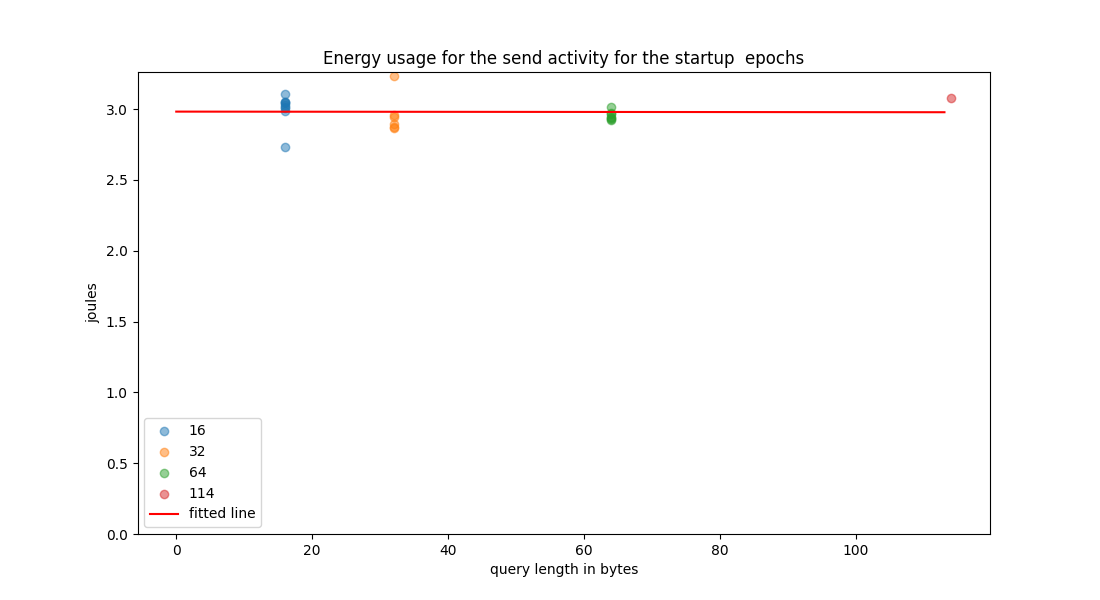

LinregressResult(slope=-3.8400559245494835e-05, intercept=2.9824025996650807, rvalue=-0.010176671076278801, pvalue=0.9632425979813937, stderr=0.000823378787491348, intercept_stderr=0.03843474078925055)


In [35]:
# SendReceive

plot_joules(first_loop_joules, "send")

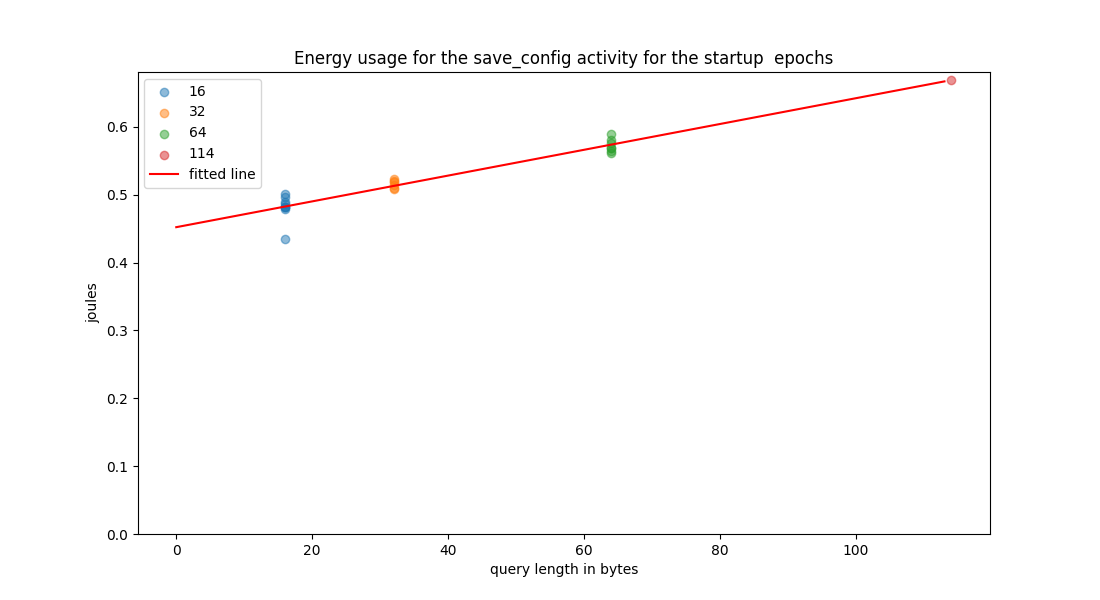

LinregressResult(slope=0.0019013044538041019, intercept=0.45215944900671123, rvalue=0.9678583670716726, pvalue=4.568066514151845e-14, stderr=0.00010781050904251349, intercept_stderr=0.005032518486456272)


In [36]:
plot_joules(first_loop_joules, "save_config")

# Steady State Analysis


| **Model Equation**                               | **Description**                               |
| ------------------------------------------------ | --------------------------------------------- |
| $SteadyEnergy_{LoadConfig} = \alpha + \beta QL$  | Load configuration energy                     |
| $SteadyEnergy_{Deserialize} = \alpha + \beta QL$ | Deserialize energy                            |
| $SteadyEnergy_{ExecTFLite} = \alpha + \beta TF$  | Execute TFLite energy (binary input)          |
| $SteadyEnergy_{ExecQuery} = \alpha + \beta QL$   | Execute query energy                          |
| $SteadyEnergy_{SendReceive} = \alpha + \beta RR$ | Send/receive energy (linear, single variable) |
| $SteadyEnergy_{SaveConfig} = \alpha + \beta QL$  | Save configuration energy                     |

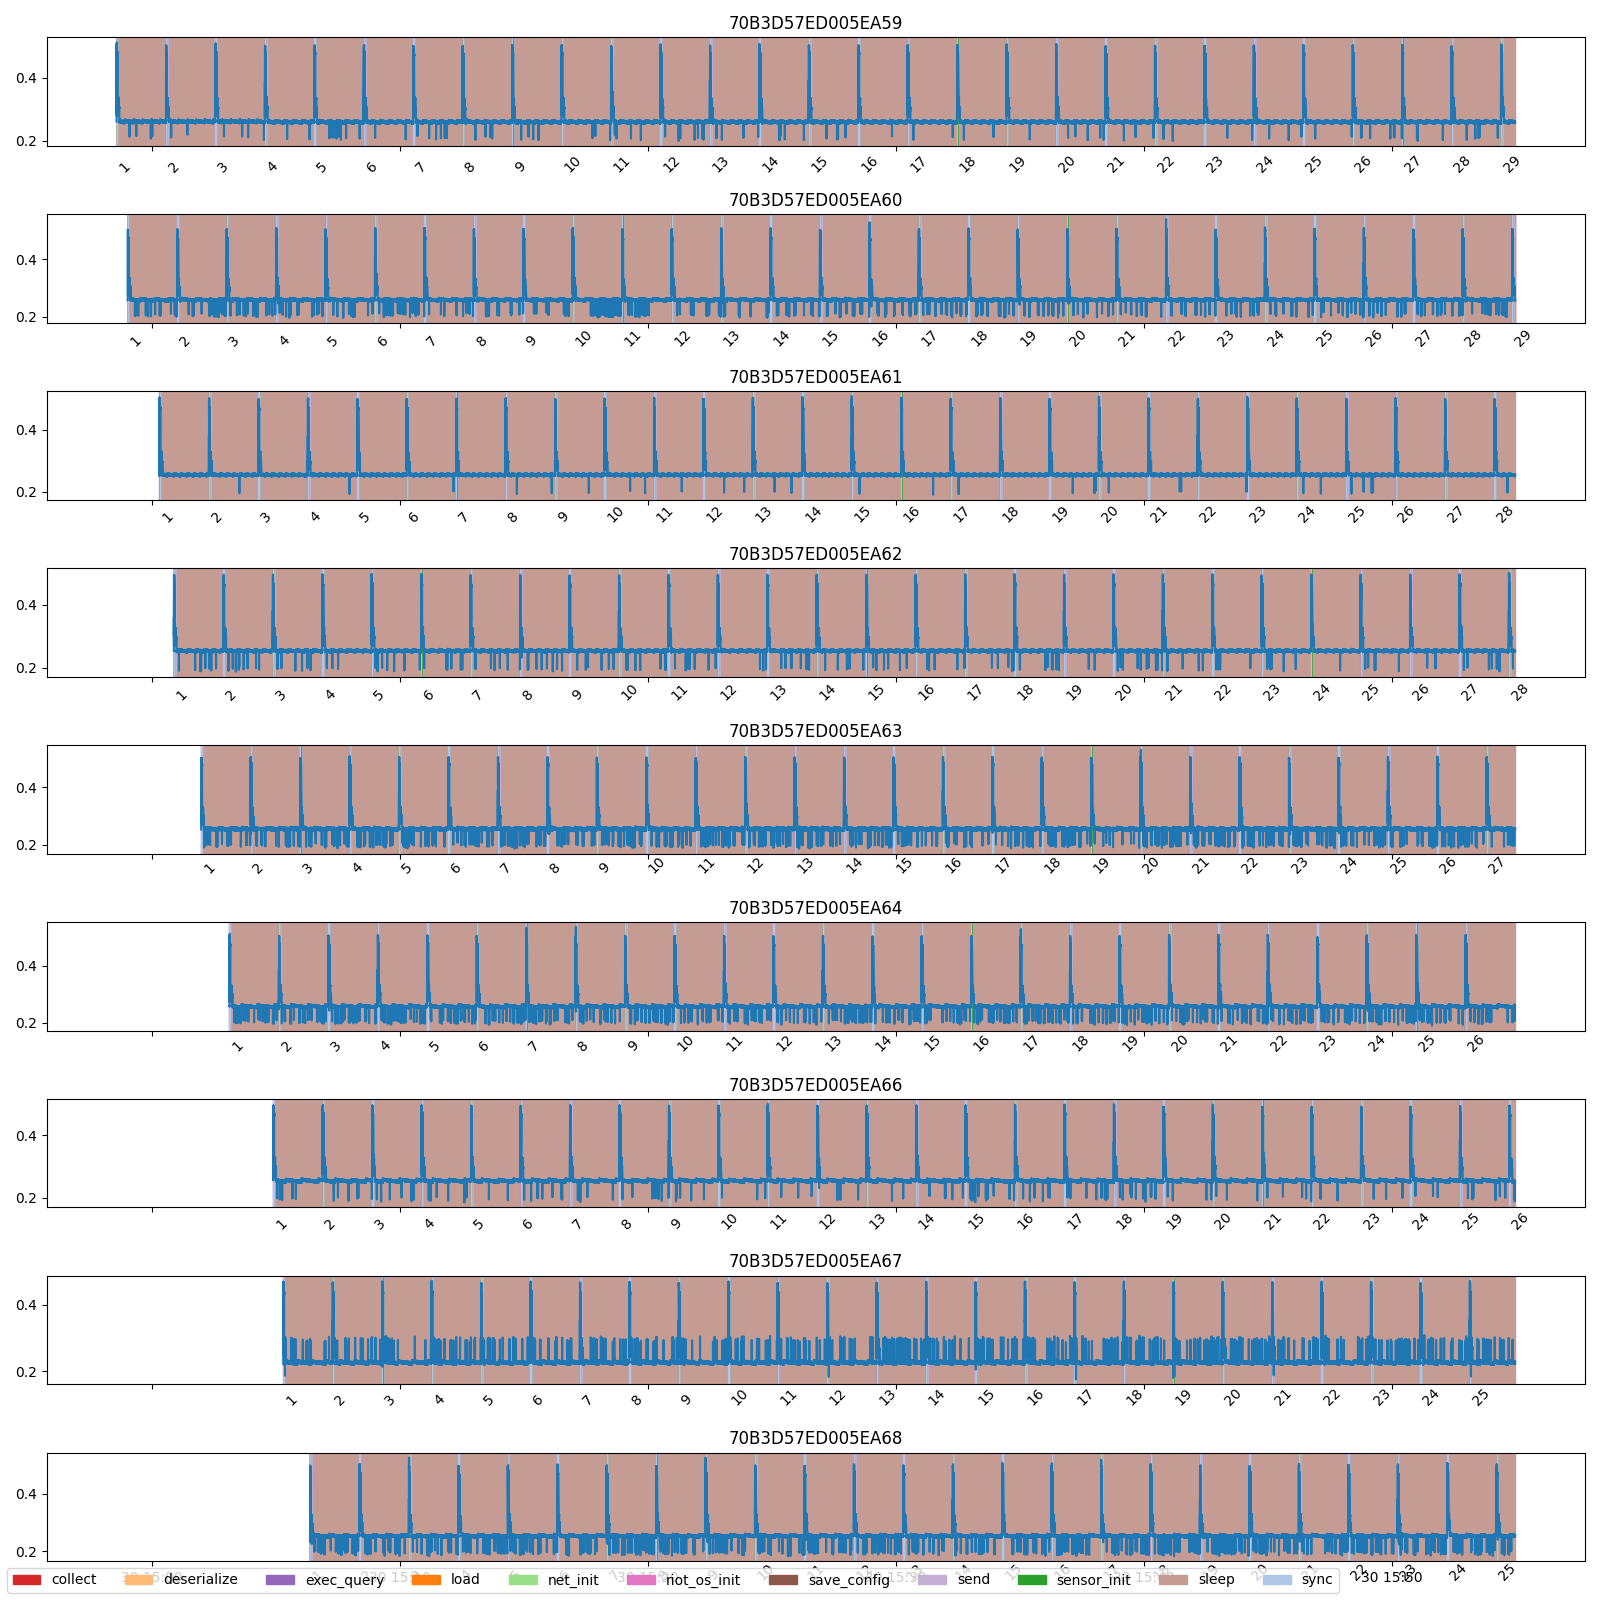

In [10]:
#for fun lets plot the loops we are gonna analyse on

df =list(experiment_dfs.values())[0]
node_ids = df["node_id"].unique()

fig, axs = plt.subplots(len(node_ids), 1, figsize=(16,16), sharex=True)

for i, node_id in enumerate(node_ids):
    # select only current node_id and loop 1+
    data = df[(df["node_id"] == node_id) & (df["loop_num"] >= 1.0) & (df["activity"] != "uncategorised")]
    timings = data.groupby(["loop_num", "activity"], observed=True)["timestamp"].agg(["first", "last"])
    for (loop, activity),v in timings.iterrows():
        axs[i].axvspan(v["first"], v["last"], alpha=1, color=colours[activity], label=activity)
    # write loop numbers on the plot
    for name, group in data.groupby(["loop_num"], observed=True)["timestamp"]:
        axs[i].text(group.iloc[0], 0.1, f"{int(name[0])}" , fontsize=10, rotation=45)

    axs[i].plot(data["timestamp"], data["power"])
    axs[i].set_title(node_id)


# avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc="lower left", ncol=len(by_label))
fig.tight_layout()
plt.show()

## LoadConfig
$SteadyEnergy_{LoadConfig} = \alpha + \beta QL$ 

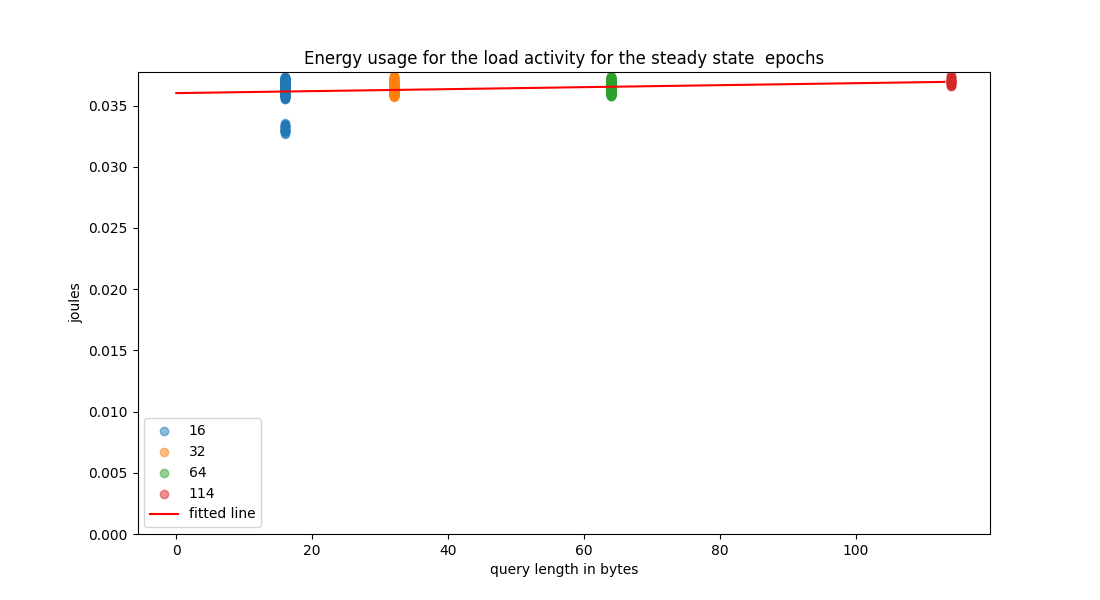

LinregressResult(slope=8.11527421487969e-06, intercept=0.036016888147487734, rvalue=0.26068286509627425, pvalue=3.891275496191391e-11, stderr=1.2060442001154923e-06, intercept_stderr=5.6319642789868385e-05)


In [37]:
plot_joules(rest_joules, "load")

$SteadyEnergy_{Deserialize} = \alpha + \beta QL$

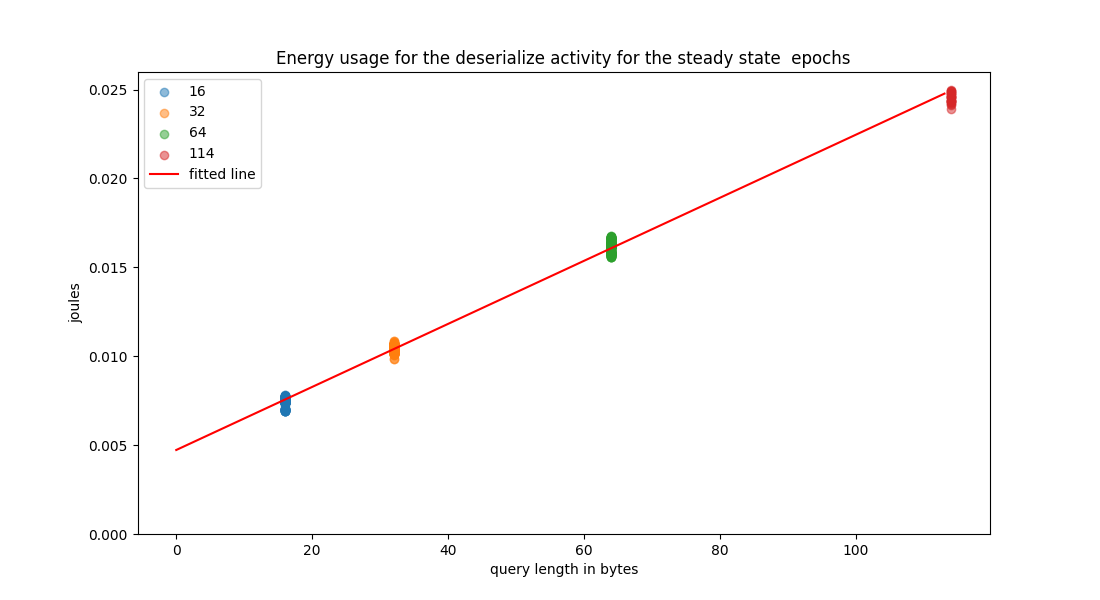

LinregressResult(slope=0.00017740640972164232, intercept=0.004725900626835058, rvalue=0.9983102175137659, pvalue=0.0, stderr=4.143857835401588e-07, intercept_stderr=1.9350915417483525e-05)


In [38]:
plot_joules(rest_joules, "deserialize")

$SteadyEnergy_{ExecQuery} = \alpha + \beta QL$ 

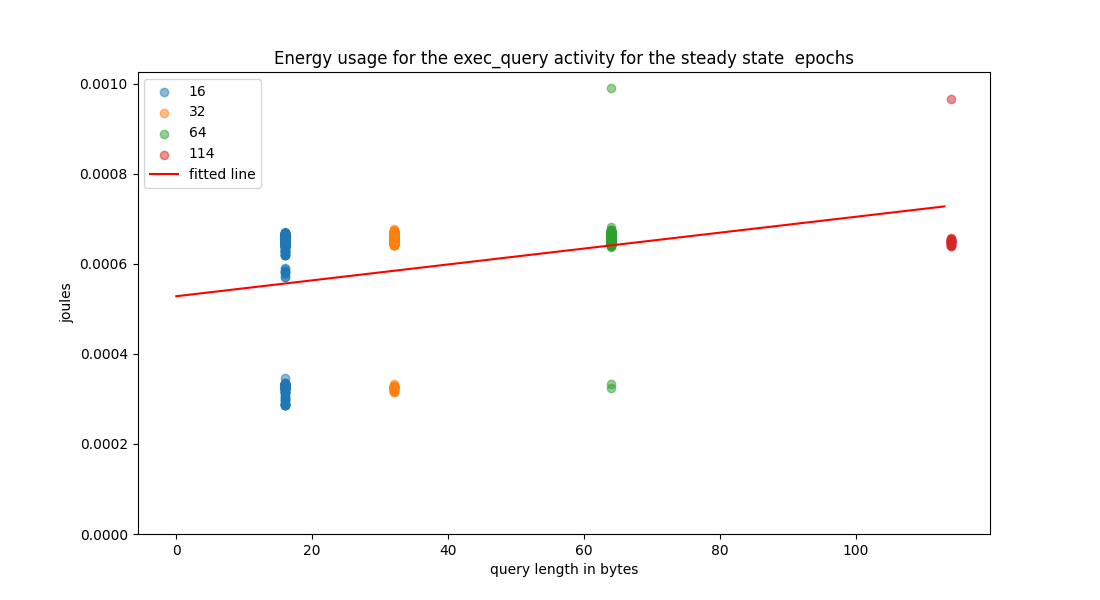

LinregressResult(slope=1.7659374557978287e-06, intercept=0.0005282417558050382, rvalue=0.35049521779668, pvalue=2.0389745162585885e-19, stderr=1.895112858931456e-07, intercept_stderr=8.856041741326444e-06)


In [39]:
plot_joules(rest_joules, "exec_query")

$SteadyEnergy_{SaveConfig} = \alpha + \beta QL$

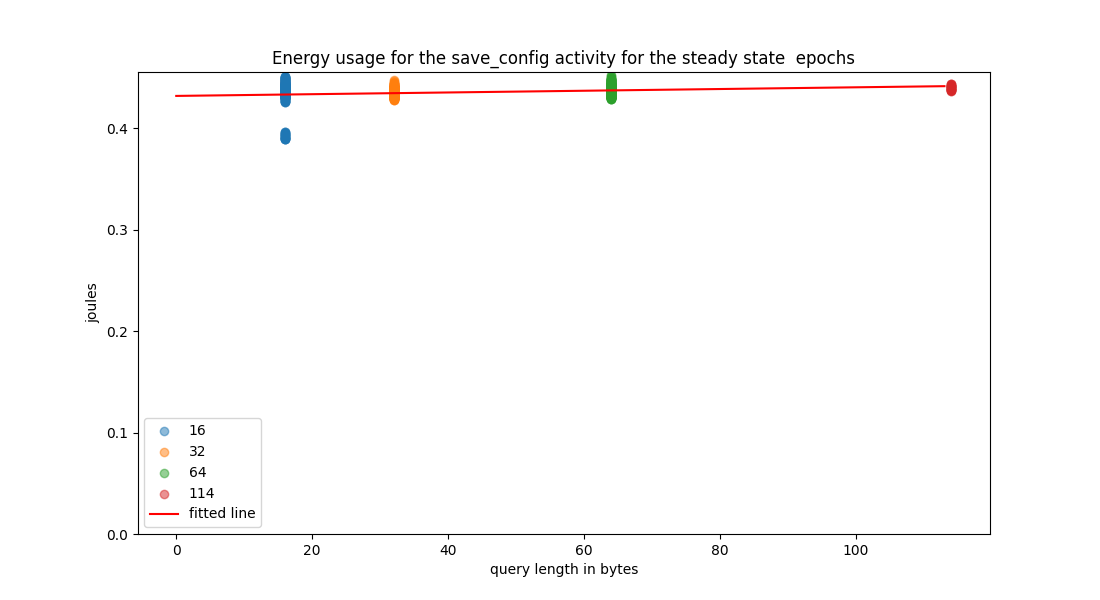

LinregressResult(slope=8.488370835912484e-05, intercept=0.43169833903030447, rvalue=0.2095878020449886, pvalue=1.2950412372222525e-07, stderr=1.5891249907051613e-05, intercept_stderr=0.0007420868307844527)


In [40]:
plot_joules(rest_joules, "save_config")

In [13]:
# lets prepare some data for plotting
data = []
averages = []
labels = []
for k,v in experiment_dfs.items():
    labels.append(k)
    group = v.groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"]
    differences = (group.last() - group.first())[idx[:,:,"deserialize"]] / np.timedelta64(1, "ms")
    averages.append(differences.mean())
    data.append(differences)

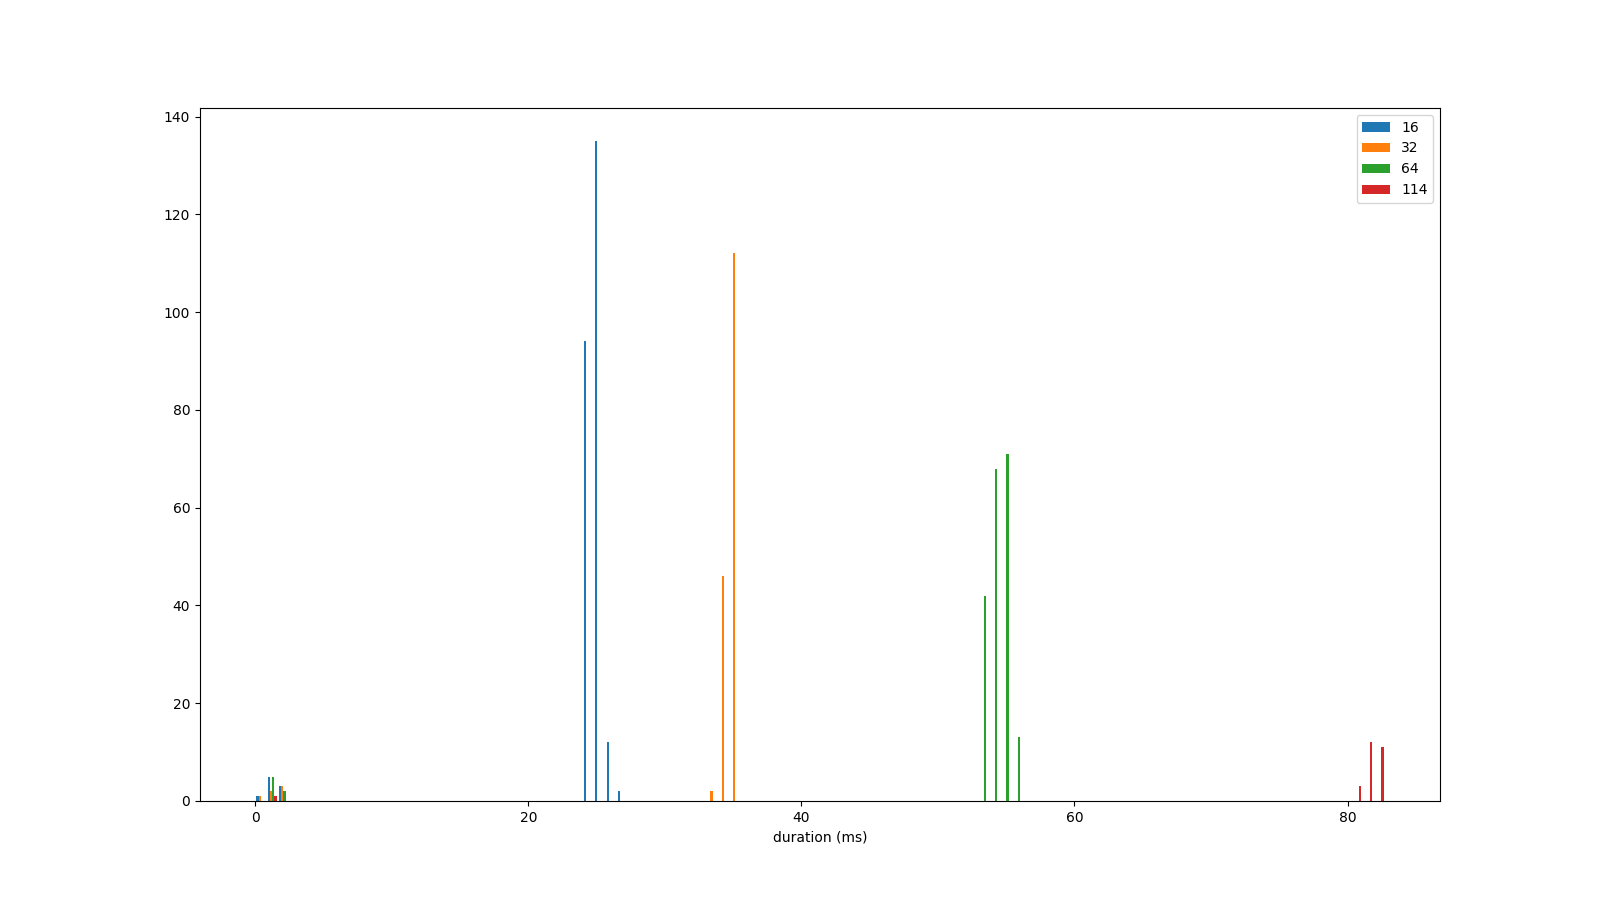

In [14]:
plt.figure(figsize=(16,9))
plt.hist(data, label=experiment_dfs.keys(), bins=100)
plt.legend()
plt.xlabel("duration (ms)")
plt.show()

KeyError: 32

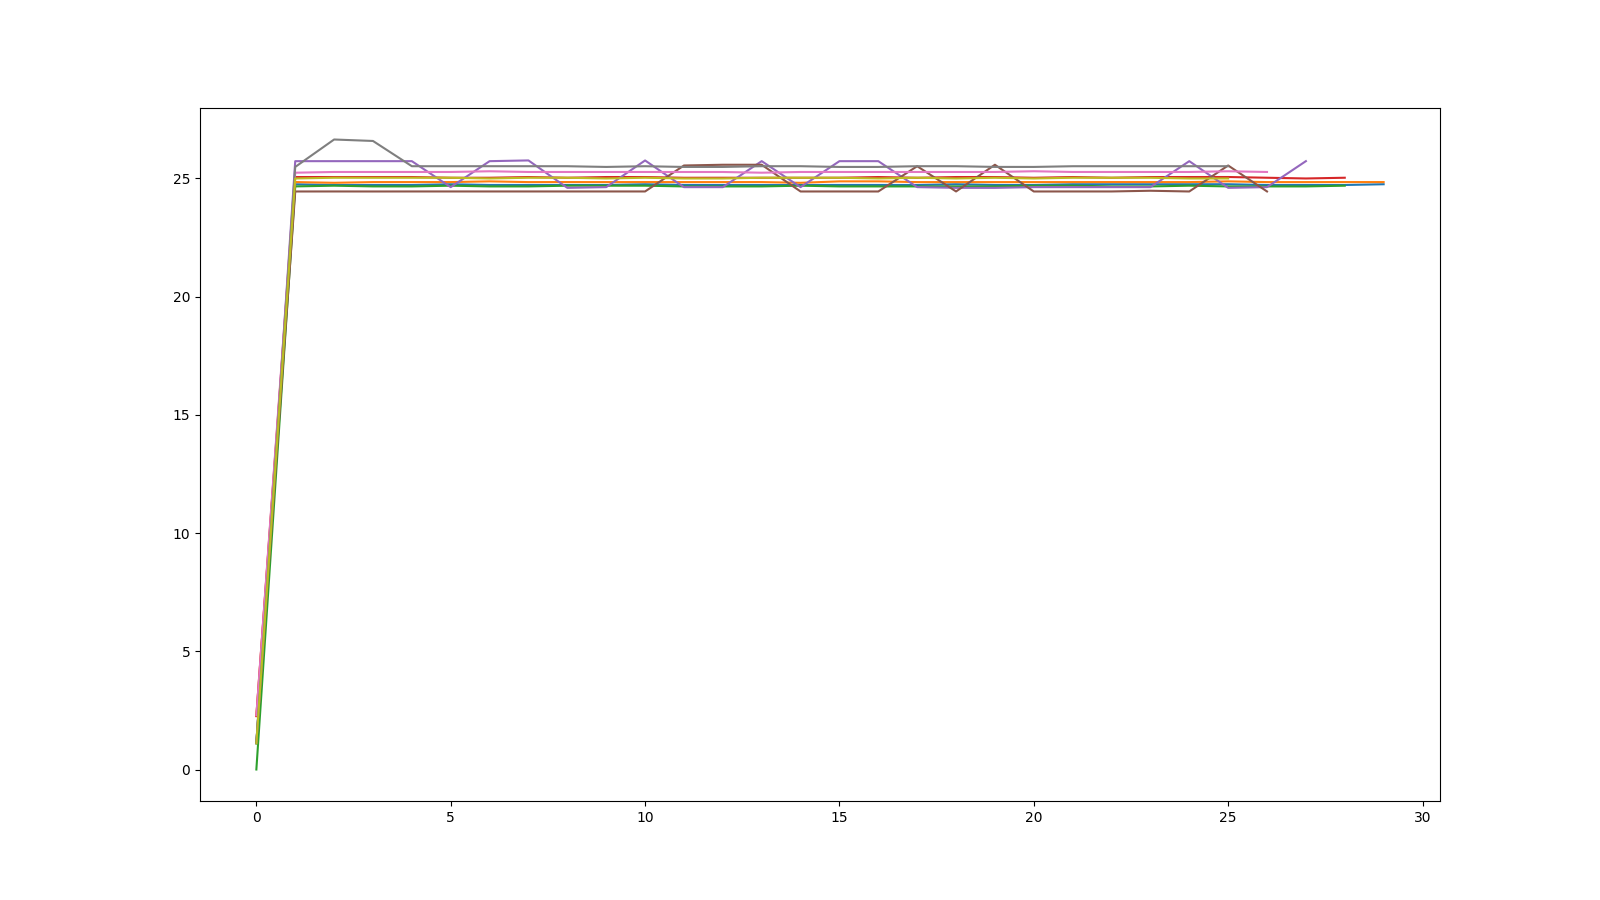

In [15]:
# lets prepare some data for plotting
styles ={
    16: "-",
    46: "--",
    114: "-.",
    214: ":"
}
plt.figure(figsize=(16,9))
for k,v in experiment_dfs.items():
    grouper = v.groupby(["node_id", "loop_num", "activity"], observed=True)["timestamp"]
    differences = (grouper.last() - grouper.first())[idx[:,:,"deserialize"]] / np.timedelta64(1, "ms")
    for name, group in differences.groupby("node_id", observed=True):
        #print()
        plt.plot(group[idx[name,:,:]], label=f"id: {name} ql: {k}", linestyle=styles[k], )
plt.legend()
plt.xlabel("loop number")
plt.ylabel("deserialization duration (ms)")
plt.show()